<a href="https://colab.research.google.com/github/marinebon/HackingLimno2025/blob/main/02_searchERDDAP4data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use `erddapy` to query multiple data servers for data of interest

In this notebook we use the package [erddapy](https://ioos.github.io/erddapy/03-advanced_search-output.html) to query for environmental data in a spitaltemporal region that aligns with our species occurrence data.

In [1]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["netCDF4", "xarray", "erddapy"]
_colab_install_missing_deps(deps)

Install netCDF4? [y/n]:y
netCDF4 installed!
Install erddapy? [y/n]:y
erddapy installed!


In [ ]:
from erddapy.multiple_server_search import advanced_search_servers

min_time = "2017-07-01T00:00:00Z"
max_time = "2025-06-10T00:00:00Z"
min_lon, max_lon = -127, -123.75
min_lat, max_lat = 43, 48
standard_name = "sea_water_temperature"

kw = {
    "standard_name": standard_name,
    "min_lon": min_lon,
    "max_lon": max_lon,
    "min_lat": min_lat,
    "max_lat": max_lat,
    "min_time": min_time,
    "max_time": max_time,
    # "cdm_data_type": "Grid",
    "protocol": "griddap"
}

df = advanced_search_servers(
    servers_list=None,
    parallel=True,
    **kw
)

df.sample(n=5)

ValueError: a must be greater than 0 unless no samples are taken

Once you have identified datasets of interest, download the relevant data into /data/.

How many servers matched our query?

In [6]:
df['Server url'].unique()

array(['https://coastwatch.pfeg.noaa.gov/erddap/',
       'https://erddap.sensors.ioos.us/erddap/',
       'http://www.neracoos.org/erddap/',
       'https://erddap.dataexplorer.oceanobservatories.org/erddap/',
       'https://upwell.pfeg.noaa.gov/erddap/'], dtype=object)

How many unique datasets did we find?

In [7]:
len(df['Dataset ID'].unique())

87

How many total datasets did we find?

In [9]:
df.shape

(88, 4)

Let's build the ERDDAP url.

In [17]:
print(f"{df['Server url'][15]}{df['Dataset ID'][15]}")

https://erddap.sensors.ioos.us/erddap/gov_ornl_cdiac_lapush_125w_48n


Let's use erddapy to query for one specific dataset and return the data.

In [22]:
from erddapy import ERDDAP

e = ERDDAP(
    server=df['Server url'][15],
    protocol="tabledap",
    response="csv",
)

e.dataset_id = df['Dataset ID'][15]

df_data = e.to_pandas(
    index_col="time (UTC)",
    parse_dates=True,
)

df_data.sample(n=5)

,latitude (degrees_north),longitude (degrees_east),z (m),pco2_in_air (microatm),pco2_in_air_qc_agg,pco2_in_air_qc_tests,pco2_in_sea_water (microatm),pco2_in_sea_water_qc_agg,pco2_in_sea_water_qc_tests,sea_water_practical_salinity (1e-3),sea_water_practical_salinity_qc_agg,sea_water_practical_salinity_qc_tests,sea_water_temperature (degree_Celsius),sea_water_temperature_qc_agg,sea_water_temperature_qc_tests,sea_water_ph_reported_on_total_scale (1),sea_water_ph_reported_on_total_scale_qc_agg,sea_water_ph_reported_on_total_scale_qc_tests,station
time (UTC),,,,,,,,,,,,,,,,,,,
2022-01-29 12:16:00+00:00,47.97,-124.95,0.0,NaN,2,NaN,NaN,2,NaN,31.497,2,NaN,8.515,2,NaN,8.096,2,NaN,NaN
2022-08-07 03:17:00+00:00,47.97,-124.95,0.0,409.9,2,NaN,258.3,2,NaN,31.047,2,NaN,13.188,2,NaN,NaN,2,NaN,NaN
2012-09-28 15:17:00+00:00,47.97,-124.95,0.0,385.6,2,NaN,356.4,2,NaN,32.075,2,NaN,12.412,2,NaN,NaN,2,NaN,NaN
2011-06-20 18:17:00+00:00,47.97,-124.95,0.0,388.4,2,NaN,171.9,2,NaN,31.346,2,NaN,12.638,2,NaN,NaN,2,NaN,NaN
2021-07-14 00:17:00+00:00,47.97,-124.95,0.0,NaN,2,NaN,NaN,2,NaN,32.066,2,NaN,12.994,2,NaN,8.026,2,NaN,NaN


Let's make a T-S diagram. Making dots colored for pco2 data.

<Axes: xlabel='sea_water_practical_salinity (1e-3)', ylabel='sea_water_temperature (degree_Celsius)'>

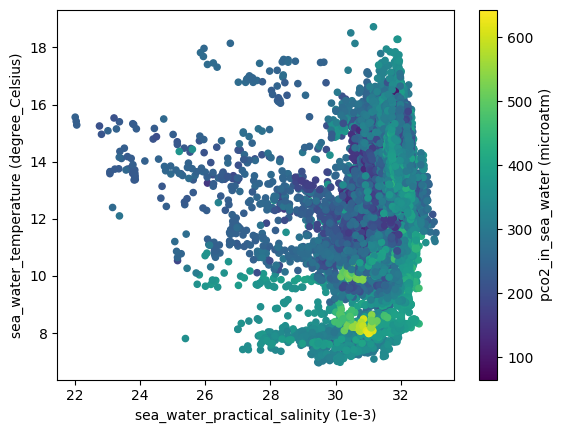

In [40]:
df_data.plot.scatter(x='sea_water_practical_salinity (1e-3)',y='sea_water_temperature (degree_Celsius)',c='pco2_in_sea_water (microatm)')

Where is this station located?

In [37]:
import plotly.express as px
import pandas as pd


# Create a scatter plot on a map
fig = px.scatter_geo(
    df_data,
    lat='latitude (degrees_north)',
    lon='longitude (degrees_east)',
    hover_name='station',
    projection='natural earth',
    title='Station on a Map',
    scope='north america',
)
fig.show()